In [ ]:
# Load Libraries 
import pandas as pd
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import time
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers
from sklearn.metrics import mean_squared_error
from tensorflow.python.keras.layers import Lambda
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import RMSprop, Adam
from keras.layers import Dense, LSTM, TimeDistributed, Flatten, Bidirectional, Input
from sklearn.preprocessing import MinMaxScaler
import h5py
import math
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from google.colab import files
from numpy import savetxt
np.random.seed(1)   
tf.random.set_seed(1)

In [ ]:
# Mount Google Drive 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Function: Create Data History
def create_timesteps(data, n_steps):
	x = []
	y = []
	for i in range(len(data)-1):
		end_ix = i + n_steps
		if end_ix > len(data)-1:
			break
		x1, y1 = data[i:end_ix, :-1], data[end_ix, -1]  
		x.append(x1)
		y.append(y1)
	return np.array(x), np.array(y)

In [ ]:
# Load the data
data1 = loadmat('/content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Data/p5271_Data.mat')
data2 = loadmat('/content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Data/p5271MechData.mat')
a_t = pd.DataFrame({'Time':data1['LocalAcTime'].ravel().round(2), 'freqQAmpI_filt':data1['freqQAmpI_filt'].ravel()})
w_t = pd.DataFrame({'Time':data1['LocalAcTime'].ravel().round(2),'C_filt':data1['C_filt'].ravel()})
m_t = pd.DataFrame({'Time':data1['Time'].ravel().round(2), 'SS':data1['SS'].ravel()}) 
s_t = pd.DataFrame({'Time':data2['Time'].ravel().round(2), 'V':data2['V'].ravel(), 'V_filt':data2['V_filt'].ravel()})
df = a_t.merge(w_t, on='Time')
df = df.merge(m_t, on='Time')
df = df.merge(s_t, on='Time')
df = df[['freqQAmpI_filt', 'C_filt','Time','V_filt','SS']]
df_SS = df[['freqQAmpI_filt','C_filt','SS']] 
df_V = df[['freqQAmpI_filt','C_filt','V_filt']] 
df_A = df[['freqQAmpI_filt','C_filt','freqQAmpI_filt']]
df_WV = df[['freqQAmpI_filt','C_filt','C_filt']]
xdf = df[['freqQAmpI_filt', 'C_filt']]
ydf = df[['SS','V_filt']]
print("Input Data:\n", xdf)
print("Target Data:\n",ydf)

Input Data:
        freqQAmpI_filt       C_filt
0        86444.183014  5713.739611
1        86444.358094  5713.748279
2        86442.647757  5713.750421
3        86419.380962  5713.758606
4        86414.552286  5713.772870
...               ...          ...
75994    81488.107323  5720.364457
75995    81375.846782  5720.365210
75996    81263.154871  5720.384980
75997    81137.502620  5720.393775
75998    80982.695515  5720.397332

[75999 rows x 2 columns]
Target Data:
              SS     V_filt
0      5.893849  10.577261
1      5.893360  10.282278
2      5.893242  10.050505
3      5.893039   9.903014
4      5.892528   9.945154
...         ...        ...
75994  5.850977   0.674248
75995  5.851531   0.653177
75996  5.852108   0.863880
75997  5.852526   0.716388
75998  5.852725   0.863880

[75999 rows x 2 columns]


In [ ]:
# Preprocessing (SS)
arr = df_SS.to_numpy()
n_steps = 300
xdf, ydf_SS = create_timesteps(arr, n_steps)

# Preprocessing (V)
arr = df_V.to_numpy()
n_steps = 300
xdf, ydf_V = create_timesteps(arr, n_steps)

# Preprocessing (A)
arr = df_A.to_numpy()
n_steps = 300
xdf, ydf_A = create_timesteps(arr, n_steps)

# Preprocessing (WV)
arr = df_WV.to_numpy()
n_steps = 300
xdf, ydf_WV = create_timesteps(arr, n_steps)

print('Features shape, X = ', np.shape(xdf))
print('Target shape (SS), Y = ', np.shape(ydf_SS))
print('Target shape (V), Y = ', np.shape(ydf_V))

# Reshape
in_dim = xdf.shape[1]*xdf.shape[2]
xdf = xdf.reshape((xdf.shape[0], in_dim))
print('After reshaping, X = ', np.shape(xdf))

Features shape, X =  (75699, 300, 2)
Target shape (SS), Y =  (75699,)
Target shape (V), Y =  (75699,)
After reshaping, X =  (75699, 600)


In [ ]:
# Split into train-val-test (SS)
x_train, x_test, y_train_SS, y_test_SS = train_test_split(xdf, ydf_SS, test_size=0.2, shuffle=False)
X_train, X_val, Y_train_SS, Y_val_SS = train_test_split(x_train, y_train_SS, test_size=0.125, shuffle=False)

# Split into train-val-test (V)
x_train, x_test, y_train_V, y_test_V = train_test_split(xdf, ydf_V, test_size=0.2, shuffle=False)
X_train, X_val, Y_train_V, Y_val_V = train_test_split(x_train, y_train_V, test_size=0.125, shuffle=False)

# Select Training Data Percentage 
X_train = X_train[45599:53199] 
Y_train_SS = Y_train_SS[45599:53199]
Y_train_V = Y_train_V[45599:53199]

# Normalize the input
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_val = pd.DataFrame(scaler.transform(X_val))
x_test = pd.DataFrame(scaler.transform(x_test))

print("Training samples:", np.shape(X_train)[0])
print("Validation samples:", np.shape(X_val)[0])
print("Testing samples:", np.shape(x_test)[0])

Training samples: 7390
Validation samples: 7570
Testing samples: 15140


In [ ]:
# Normalize the output: SS
scaler_ss = MinMaxScaler()
Y_train_SS = pd.DataFrame(scaler_ss.fit_transform(Y_train_SS.reshape(-1, 1)))
Y_val_SS = pd.DataFrame(scaler_ss.transform(Y_val_SS.reshape(-1, 1)))
y_test_SS = pd.DataFrame(scaler_ss.transform(y_test_SS.reshape(-1, 1)))

In [ ]:
# Normalize the output: V
scaler_v = MinMaxScaler()
Y_train_V = pd.DataFrame(scaler_v.fit_transform(Y_train_V.reshape(-1, 1)))
Y_val_V = pd.DataFrame(scaler_v.transform(Y_val_V.reshape(-1, 1)))
y_test_V = pd.DataFrame(scaler_v.transform(y_test_V.reshape(-1, 1)))

**Define Data-Driven Model**

In [ ]:
# Define MLP
def MLP_Data():

  # Define inputs
  X_train = layers.Input(shape=(600),name='X_train')    

  # Prediction: Shear Stress + Slip Rate 
  x = layers.Dense(128,kernel_initializer = 'normal', activation="relu")(X_train)
  x = layers.Dense(64,kernel_initializer = 'normal', activation="relu")(x)
  x = layers.Dense(32,kernel_initializer = 'normal', activation="relu")(x)
  x = layers.Dense(16, kernel_initializer = 'normal', activation="relu")(x)
  x = layers.Dense(8, kernel_initializer = 'normal', activation="relu")(x)
  ss_pred = layers.Dense(1,kernel_initializer = 'normal',activation="linear")(x)
  v_pred = layers.Dense(1,kernel_initializer = 'normal',activation="linear")(x)

  model = keras.Model(inputs=[X_train],outputs=[ss_pred,v_pred])
  return model

In [ ]:
# Model Summary
model=MLP_Data()
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(1e-3), metrics=['mse'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 X_train (InputLayer)           [(None, 600)]        0           []                               
                                                                                                  
 dense_7 (Dense)                (None, 128)          76928       ['X_train[0][0]']                
                                                                                                  
 dense_8 (Dense)                (None, 64)           8256        ['dense_7[0][0]']                
                                                                                                  
 dense_9 (Dense)                (None, 32)           2080        ['dense_8[0][0]']                
                                                                                            

Train on 7390 samples, validate on 7570 samples
Epoch 1/100
6912/7390 [===========================>..] - ETA: 0s - loss: 0.0868 - dense_12_loss: 0.0758 - dense_13_loss: 0.0109 - dense_12_mse: 0.0758 - dense_13_mse: 0.0109

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates



Epoch 1: val_loss improved from inf to 0.04261, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Standalone/Check


7390/7390 [==============================] - 2s 317us/sample - loss: 0.0828 - dense_12_loss: 0.0723 - dense_13_loss: 0.0104 - dense_12_mse: 0.0724 - dense_13_mse: 0.0105 - val_loss: 0.0426 - val_dense_12_loss: 0.0321 - val_dense_13_loss: 0.0105 - val_dense_12_mse: 0.0321 - val_dense_13_mse: 0.0105
Epoch 2/100
7072/7390 [===========================>..] - ETA: 0s - loss: 0.0296 - dense_12_loss: 0.0198 - dense_13_loss: 0.0098 - dense_12_mse: 0.0198 - dense_13_mse: 0.0098
Epoch 2: val_loss improved from 0.04261 to 0.03222, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Standalone/Check


7390/7390 [==============================] - 2s 294us/sample - loss: 0.0294 - dense_12_loss: 0.0197 - dense_13_loss: 0.0097 - dense_12_mse: 0.0197 - dense_13_mse: 0.0097 - val_loss: 0.0322 - val_dense_12_loss: 0.0218 - val_dense_13_loss: 0.0104 - val_dense_12_mse: 0.0218 - val_dense_13_mse: 0.0105
Epoch 3/100
6944/7390 [===========================>..] - ETA: 0s - loss: 0.0280 - dense_12_loss: 0.0185 - dense_13_loss: 0.0095 - dense_12_mse: 0.0185 - dense_13_mse: 0.0095
Epoch 3: val_loss improved from 0.03222 to 0.03137, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Standalone/Check


7390/7390 [==============================] - 3s 439us/sample - loss: 0.0280 - dense_12_loss: 0.0184 - dense_13_loss: 0.0096 - dense_12_mse: 0.0184 - dense_13_mse: 0.0096 - val_loss: 0.0314 - val_dense_12_loss: 0.0205 - val_dense_13_loss: 0.0108 - val_dense_12_mse: 0.0205 - val_dense_13_mse: 0.0109
Epoch 4/100
7328/7390 [============================>.] - ETA: 0s - loss: 0.0275 - dense_12_loss: 0.0179 - dense_13_loss: 0.0096 - dense_12_mse: 0.0179 - dense_13_mse: 0.0096
Epoch 4: val_loss improved from 0.03137 to 0.02930, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Standalone/Check


7390/7390 [==============================] - 3s 360us/sample - loss: 0.0274 - dense_12_loss: 0.0179 - dense_13_loss: 0.0095 - dense_12_mse: 0.0179 - dense_13_mse: 0.0095 - val_loss: 0.0293 - val_dense_12_loss: 0.0190 - val_dense_13_loss: 0.0103 - val_dense_12_mse: 0.0190 - val_dense_13_mse: 0.0103
Epoch 5/100
6848/7390 [==========================>...] - ETA: 0s - loss: 0.0268 - dense_12_loss: 0.0171 - dense_13_loss: 0.0097 - dense_12_mse: 0.0171 - dense_13_mse: 0.0097
Epoch 5: val_loss did not improve from 0.02930
7390/7390 [==============================] - 1s 109us/sample - loss: 0.0267 - dense_12_loss: 0.0172 - dense_13_loss: 0.0095 - dense_12_mse: 0.0172 - dense_13_mse: 0.0095 - val_loss: 0.0307 - val_dense_12_loss: 0.0205 - val_dense_13_loss: 0.0103 - val_dense_12_mse: 0.0205 - val_dense_13_mse: 0.0103
Epoch 6/100
7296/7390 [============================>.] - ETA: 0s - loss: 0.0261 - dense_12_loss: 0.0167 - dense_13_loss: 0.0095 - dense_12_mse: 0.0167 - dense_13_mse: 0.0095
Epoch 6

7390/7390 [==============================] - 2s 285us/sample - loss: 0.0261 - dense_12_loss: 0.0166 - dense_13_loss: 0.0094 - dense_12_mse: 0.0166 - dense_13_mse: 0.0094 - val_loss: 0.0271 - val_dense_12_loss: 0.0168 - val_dense_13_loss: 0.0103 - val_dense_12_mse: 0.0168 - val_dense_13_mse: 0.0103
Epoch 7/100
7104/7390 [===========================>..] - ETA: 0s - loss: 0.0254 - dense_12_loss: 0.0162 - dense_13_loss: 0.0092 - dense_12_mse: 0.0162 - dense_13_mse: 0.0092
Epoch 7: val_loss improved from 0.02705 to 0.02698, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Standalone/Check


7390/7390 [==============================] - 2s 295us/sample - loss: 0.0255 - dense_12_loss: 0.0161 - dense_13_loss: 0.0094 - dense_12_mse: 0.0161 - dense_13_mse: 0.0094 - val_loss: 0.0270 - val_dense_12_loss: 0.0167 - val_dense_13_loss: 0.0102 - val_dense_12_mse: 0.0167 - val_dense_13_mse: 0.0103
Epoch 8/100
6816/7390 [==========================>...] - ETA: 0s - loss: 0.0246 - dense_12_loss: 0.0153 - dense_13_loss: 0.0093 - dense_12_mse: 0.0153 - dense_13_mse: 0.0093
Epoch 8: val_loss did not improve from 0.02698
7390/7390 [==============================] - 1s 110us/sample - loss: 0.0249 - dense_12_loss: 0.0155 - dense_13_loss: 0.0094 - dense_12_mse: 0.0155 - dense_13_mse: 0.0094 - val_loss: 0.0275 - val_dense_12_loss: 0.0172 - val_dense_13_loss: 0.0102 - val_dense_12_mse: 0.0172 - val_dense_13_mse: 0.0103
Epoch 9/100
7328/7390 [============================>.] - ETA: 0s - loss: 0.0242 - dense_12_loss: 0.0147 - dense_13_loss: 0.0094 - dense_12_mse: 0.0147 - dense_13_mse: 0.0094
Epoch 9

7390/7390 [==============================] - 2s 288us/sample - loss: 0.0234 - dense_12_loss: 0.0140 - dense_13_loss: 0.0094 - dense_12_mse: 0.0140 - dense_13_mse: 0.0094 - val_loss: 0.0265 - val_dense_12_loss: 0.0162 - val_dense_13_loss: 0.0103 - val_dense_12_mse: 0.0162 - val_dense_13_mse: 0.0103
Epoch 11/100
7168/7390 [============================>.] - ETA: 0s - loss: 0.0226 - dense_12_loss: 0.0132 - dense_13_loss: 0.0093 - dense_12_mse: 0.0132 - dense_13_mse: 0.0093
Epoch 11: val_loss improved from 0.02647 to 0.02644, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Standalone/Check


7390/7390 [==============================] - 2s 325us/sample - loss: 0.0226 - dense_12_loss: 0.0132 - dense_13_loss: 0.0094 - dense_12_mse: 0.0132 - dense_13_mse: 0.0094 - val_loss: 0.0264 - val_dense_12_loss: 0.0161 - val_dense_13_loss: 0.0103 - val_dense_12_mse: 0.0161 - val_dense_13_mse: 0.0103
Epoch 12/100
7072/7390 [===========================>..] - ETA: 0s - loss: 0.0225 - dense_12_loss: 0.0132 - dense_13_loss: 0.0092 - dense_12_mse: 0.0132 - dense_13_mse: 0.0092
Epoch 12: val_loss improved from 0.02644 to 0.02522, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Standalone/Check


7390/7390 [==============================] - 2s 290us/sample - loss: 0.0226 - dense_12_loss: 0.0132 - dense_13_loss: 0.0094 - dense_12_mse: 0.0132 - dense_13_mse: 0.0094 - val_loss: 0.0252 - val_dense_12_loss: 0.0150 - val_dense_13_loss: 0.0102 - val_dense_12_mse: 0.0150 - val_dense_13_mse: 0.0102
Epoch 13/100
7264/7390 [============================>.] - ETA: 0s - loss: 0.0222 - dense_12_loss: 0.0128 - dense_13_loss: 0.0094 - dense_12_mse: 0.0128 - dense_13_mse: 0.0094
Epoch 13: val_loss did not improve from 0.02522
7390/7390 [==============================] - 1s 107us/sample - loss: 0.0222 - dense_12_loss: 0.0128 - dense_13_loss: 0.0094 - dense_12_mse: 0.0128 - dense_13_mse: 0.0094 - val_loss: 0.0269 - val_dense_12_loss: 0.0166 - val_dense_13_loss: 0.0103 - val_dense_12_mse: 0.0166 - val_dense_13_mse: 0.0103
Epoch 14/100
7264/7390 [============================>.] - ETA: 0s - loss: 0.0215 - dense_12_loss: 0.0122 - dense_13_loss: 0.0093 - dense_12_mse: 0.0122 - dense_13_mse: 0.0093
Epoc

7390/7390 [==============================] - 2s 281us/sample - loss: 0.0208 - dense_12_loss: 0.0114 - dense_13_loss: 0.0094 - dense_12_mse: 0.0114 - dense_13_mse: 0.0094 - val_loss: 0.0241 - val_dense_12_loss: 0.0139 - val_dense_13_loss: 0.0102 - val_dense_12_mse: 0.0139 - val_dense_13_mse: 0.0102
Epoch 17/100
7296/7390 [============================>.] - ETA: 0s - loss: 0.0205 - dense_12_loss: 0.0111 - dense_13_loss: 0.0095 - dense_12_mse: 0.0111 - dense_13_mse: 0.0095
Epoch 17: val_loss improved from 0.02406 to 0.02303, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Standalone/Check


7390/7390 [==============================] - 2s 287us/sample - loss: 0.0204 - dense_12_loss: 0.0111 - dense_13_loss: 0.0094 - dense_12_mse: 0.0111 - dense_13_mse: 0.0094 - val_loss: 0.0230 - val_dense_12_loss: 0.0129 - val_dense_13_loss: 0.0102 - val_dense_12_mse: 0.0129 - val_dense_13_mse: 0.0102
Epoch 18/100
7136/7390 [===========================>..] - ETA: 0s - loss: 0.0188 - dense_12_loss: 0.0093 - dense_13_loss: 0.0095 - dense_12_mse: 0.0093 - dense_13_mse: 0.0095
Epoch 18: val_loss did not improve from 0.02303
7390/7390 [==============================] - 1s 108us/sample - loss: 0.0188 - dense_12_loss: 0.0095 - dense_13_loss: 0.0094 - dense_12_mse: 0.0095 - dense_13_mse: 0.0094 - val_loss: 0.0272 - val_dense_12_loss: 0.0170 - val_dense_13_loss: 0.0104 - val_dense_12_mse: 0.0169 - val_dense_13_mse: 0.0103
Epoch 19/100
6752/7390 [==========================>...] - ETA: 0s - loss: 0.0182 - dense_12_loss: 0.0088 - dense_13_loss: 0.0094 - dense_12_mse: 0.0088 - dense_13_mse: 0.0094
Epoc

7390/7390 [==============================] - 2s 294us/sample - loss: 0.0181 - dense_12_loss: 0.0088 - dense_13_loss: 0.0093 - dense_12_mse: 0.0088 - dense_13_mse: 0.0093 - val_loss: 0.0226 - val_dense_12_loss: 0.0127 - val_dense_13_loss: 0.0100 - val_dense_12_mse: 0.0126 - val_dense_13_mse: 0.0100
Epoch 20/100
7104/7390 [===========================>..] - ETA: 0s - loss: 0.0177 - dense_12_loss: 0.0084 - dense_13_loss: 0.0092 - dense_12_mse: 0.0084 - dense_13_mse: 0.0092
Epoch 20: val_loss improved from 0.02263 to 0.02128, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Standalone/Check


7390/7390 [==============================] - 2s 327us/sample - loss: 0.0173 - dense_12_loss: 0.0084 - dense_13_loss: 0.0090 - dense_12_mse: 0.0084 - dense_13_mse: 0.0090 - val_loss: 0.0213 - val_dense_12_loss: 0.0117 - val_dense_13_loss: 0.0096 - val_dense_12_mse: 0.0117 - val_dense_13_mse: 0.0096
Epoch 21/100
6784/7390 [==========================>...] - ETA: 0s - loss: 0.0162 - dense_12_loss: 0.0076 - dense_13_loss: 0.0086 - dense_12_mse: 0.0076 - dense_13_mse: 0.0086
Epoch 21: val_loss improved from 0.02128 to 0.02108, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Standalone/Check


7390/7390 [==============================] - 2s 289us/sample - loss: 0.0159 - dense_12_loss: 0.0074 - dense_13_loss: 0.0084 - dense_12_mse: 0.0074 - dense_13_mse: 0.0084 - val_loss: 0.0211 - val_dense_12_loss: 0.0119 - val_dense_13_loss: 0.0093 - val_dense_12_mse: 0.0119 - val_dense_13_mse: 0.0092
Epoch 22/100
6944/7390 [===========================>..] - ETA: 0s - loss: 0.0148 - dense_12_loss: 0.0070 - dense_13_loss: 0.0079 - dense_12_mse: 0.0070 - dense_13_mse: 0.0079
Epoch 22: val_loss improved from 0.02108 to 0.02025, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Standalone/Check


7390/7390 [==============================] - 2s 287us/sample - loss: 0.0146 - dense_12_loss: 0.0069 - dense_13_loss: 0.0077 - dense_12_mse: 0.0069 - dense_13_mse: 0.0077 - val_loss: 0.0202 - val_dense_12_loss: 0.0116 - val_dense_13_loss: 0.0086 - val_dense_12_mse: 0.0116 - val_dense_13_mse: 0.0086
Epoch 23/100
7264/7390 [============================>.] - ETA: 0s - loss: 0.0128 - dense_12_loss: 0.0067 - dense_13_loss: 0.0061 - dense_12_mse: 0.0067 - dense_13_mse: 0.0061
Epoch 23: val_loss improved from 0.02025 to 0.01370, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Standalone/Check


7390/7390 [==============================] - 2s 291us/sample - loss: 0.0128 - dense_12_loss: 0.0067 - dense_13_loss: 0.0061 - dense_12_mse: 0.0067 - dense_13_mse: 0.0061 - val_loss: 0.0137 - val_dense_12_loss: 0.0080 - val_dense_13_loss: 0.0057 - val_dense_12_mse: 0.0080 - val_dense_13_mse: 0.0057
Epoch 24/100
6976/7390 [===========================>..] - ETA: 0s - loss: 0.0105 - dense_12_loss: 0.0059 - dense_13_loss: 0.0045 - dense_12_mse: 0.0059 - dense_13_mse: 0.0045
Epoch 24: val_loss improved from 0.01370 to 0.01138, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Standalone/Check


7390/7390 [==============================] - 2s 323us/sample - loss: 0.0104 - dense_12_loss: 0.0059 - dense_13_loss: 0.0045 - dense_12_mse: 0.0059 - dense_13_mse: 0.0045 - val_loss: 0.0114 - val_dense_12_loss: 0.0068 - val_dense_13_loss: 0.0046 - val_dense_12_mse: 0.0068 - val_dense_13_mse: 0.0046
Epoch 25/100
7104/7390 [===========================>..] - ETA: 0s - loss: 0.0092 - dense_12_loss: 0.0058 - dense_13_loss: 0.0034 - dense_12_mse: 0.0058 - dense_13_mse: 0.0034
Epoch 25: val_loss improved from 0.01138 to 0.00967, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Standalone/Check


7390/7390 [==============================] - 2s 293us/sample - loss: 0.0091 - dense_12_loss: 0.0057 - dense_13_loss: 0.0034 - dense_12_mse: 0.0057 - dense_13_mse: 0.0034 - val_loss: 0.0097 - val_dense_12_loss: 0.0072 - val_dense_13_loss: 0.0025 - val_dense_12_mse: 0.0072 - val_dense_13_mse: 0.0025
Epoch 26/100
7104/7390 [===========================>..] - ETA: 0s - loss: 0.0075 - dense_12_loss: 0.0050 - dense_13_loss: 0.0025 - dense_12_mse: 0.0050 - dense_13_mse: 0.0025
Epoch 26: val_loss improved from 0.00967 to 0.00775, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Standalone/Check


7390/7390 [==============================] - 2s 291us/sample - loss: 0.0075 - dense_12_loss: 0.0050 - dense_13_loss: 0.0025 - dense_12_mse: 0.0050 - dense_13_mse: 0.0025 - val_loss: 0.0078 - val_dense_12_loss: 0.0051 - val_dense_13_loss: 0.0026 - val_dense_12_mse: 0.0051 - val_dense_13_mse: 0.0027
Epoch 27/100
6848/7390 [==========================>...] - ETA: 0s - loss: 0.0075 - dense_12_loss: 0.0050 - dense_13_loss: 0.0025 - dense_12_mse: 0.0050 - dense_13_mse: 0.0025
Epoch 27: val_loss did not improve from 0.00775
7390/7390 [==============================] - 1s 109us/sample - loss: 0.0074 - dense_12_loss: 0.0049 - dense_13_loss: 0.0025 - dense_12_mse: 0.0049 - dense_13_mse: 0.0025 - val_loss: 0.0096 - val_dense_12_loss: 0.0057 - val_dense_13_loss: 0.0040 - val_dense_12_mse: 0.0057 - val_dense_13_mse: 0.0040
Epoch 28/100
7232/7390 [============================>.] - ETA: 0s - loss: 0.0066 - dense_12_loss: 0.0045 - dense_13_loss: 0.0022 - dense_12_mse: 0.0045 - dense_13_mse: 0.0022
Epoc

7390/7390 [==============================] - 2s 296us/sample - loss: 0.0066 - dense_12_loss: 0.0045 - dense_13_loss: 0.0021 - dense_12_mse: 0.0045 - dense_13_mse: 0.0021 - val_loss: 0.0068 - val_dense_12_loss: 0.0049 - val_dense_13_loss: 0.0020 - val_dense_12_mse: 0.0049 - val_dense_13_mse: 0.0020
Epoch 29/100
6944/7390 [===========================>..] - ETA: 0s - loss: 0.0067 - dense_12_loss: 0.0044 - dense_13_loss: 0.0022 - dense_12_mse: 0.0044 - dense_13_mse: 0.0022
Epoch 29: val_loss improved from 0.00684 to 0.00634, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Standalone/Check


7390/7390 [==============================] - 2s 294us/sample - loss: 0.0066 - dense_12_loss: 0.0044 - dense_13_loss: 0.0022 - dense_12_mse: 0.0044 - dense_13_mse: 0.0022 - val_loss: 0.0063 - val_dense_12_loss: 0.0046 - val_dense_13_loss: 0.0018 - val_dense_12_mse: 0.0046 - val_dense_13_mse: 0.0018
Epoch 30/100
7360/7390 [============================>.] - ETA: 0s - loss: 0.0059 - dense_12_loss: 0.0040 - dense_13_loss: 0.0019 - dense_12_mse: 0.0040 - dense_13_mse: 0.0019
Epoch 30: val_loss did not improve from 0.00634
7390/7390 [==============================] - 1s 106us/sample - loss: 0.0059 - dense_12_loss: 0.0040 - dense_13_loss: 0.0019 - dense_12_mse: 0.0040 - dense_13_mse: 0.0019 - val_loss: 0.0079 - val_dense_12_loss: 0.0047 - val_dense_13_loss: 0.0032 - val_dense_12_mse: 0.0047 - val_dense_13_mse: 0.0032
Epoch 31/100
7008/7390 [===========================>..] - ETA: 0s - loss: 0.0062 - dense_12_loss: 0.0040 - dense_13_loss: 0.0021 - dense_12_mse: 0.0040 - dense_13_mse: 0.0021
Epoc

7390/7390 [==============================] - 2s 323us/sample - loss: 0.0062 - dense_12_loss: 0.0040 - dense_13_loss: 0.0021 - dense_12_mse: 0.0040 - dense_13_mse: 0.0021 - val_loss: 0.0060 - val_dense_12_loss: 0.0041 - val_dense_13_loss: 0.0019 - val_dense_12_mse: 0.0041 - val_dense_13_mse: 0.0019
Epoch 32/100
6816/7390 [==========================>...] - ETA: 0s - loss: 0.0054 - dense_12_loss: 0.0037 - dense_13_loss: 0.0017 - dense_12_mse: 0.0037 - dense_13_mse: 0.0017
Epoch 32: val_loss did not improve from 0.00599
7390/7390 [==============================] - 1s 109us/sample - loss: 0.0053 - dense_12_loss: 0.0036 - dense_13_loss: 0.0017 - dense_12_mse: 0.0036 - dense_13_mse: 0.0017 - val_loss: 0.0075 - val_dense_12_loss: 0.0048 - val_dense_13_loss: 0.0027 - val_dense_12_mse: 0.0048 - val_dense_13_mse: 0.0027
Epoch 33/100
7008/7390 [===========================>..] - ETA: 0s - loss: 0.0054 - dense_12_loss: 0.0037 - dense_13_loss: 0.0017 - dense_12_mse: 0.0037 - dense_13_mse: 0.0017
Epoc

7390/7390 [==============================] - 2s 292us/sample - loss: 0.0048 - dense_12_loss: 0.0032 - dense_13_loss: 0.0016 - dense_12_mse: 0.0032 - dense_13_mse: 0.0016 - val_loss: 0.0056 - val_dense_12_loss: 0.0041 - val_dense_13_loss: 0.0015 - val_dense_12_mse: 0.0041 - val_dense_13_mse: 0.0015
Epoch 40/100
7136/7390 [===========================>..] - ETA: 0s - loss: 0.0044 - dense_12_loss: 0.0032 - dense_13_loss: 0.0013 - dense_12_mse: 0.0032 - dense_13_mse: 0.0013
Epoch 40: val_loss improved from 0.00556 to 0.00548, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Standalone/Check


7390/7390 [==============================] - 2s 301us/sample - loss: 0.0044 - dense_12_loss: 0.0032 - dense_13_loss: 0.0013 - dense_12_mse: 0.0032 - dense_13_mse: 0.0013 - val_loss: 0.0055 - val_dense_12_loss: 0.0041 - val_dense_13_loss: 0.0014 - val_dense_12_mse: 0.0041 - val_dense_13_mse: 0.0014
Epoch 41/100
6720/7390 [==========================>...] - ETA: 0s - loss: 0.0045 - dense_12_loss: 0.0031 - dense_13_loss: 0.0014 - dense_12_mse: 0.0031 - dense_13_mse: 0.0014
Epoch 41: val_loss did not improve from 0.00548
7390/7390 [==============================] - 1s 109us/sample - loss: 0.0045 - dense_12_loss: 0.0031 - dense_13_loss: 0.0014 - dense_12_mse: 0.0031 - dense_13_mse: 0.0014 - val_loss: 0.0057 - val_dense_12_loss: 0.0040 - val_dense_13_loss: 0.0018 - val_dense_12_mse: 0.0039 - val_dense_13_mse: 0.0018
Epoch 42/100
6944/7390 [===========================>..] - ETA: 0s - loss: 0.0044 - dense_12_loss: 0.0031 - dense_13_loss: 0.0013 - dense_12_mse: 0.0031 - dense_13_mse: 0.0013
Epoc

7390/7390 [==============================] - 2s 298us/sample - loss: 0.0047 - dense_12_loss: 0.0032 - dense_13_loss: 0.0015 - dense_12_mse: 0.0032 - dense_13_mse: 0.0015 - val_loss: 0.0053 - val_dense_12_loss: 0.0038 - val_dense_13_loss: 0.0015 - val_dense_12_mse: 0.0038 - val_dense_13_mse: 0.0015
Epoch 46/100
7040/7390 [===========================>..] - ETA: 0s - loss: 0.0037 - dense_12_loss: 0.0027 - dense_13_loss: 0.0010 - dense_12_mse: 0.0027 - dense_13_mse: 0.0010
Epoch 46: val_loss improved from 0.00529 to 0.00483, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Standalone/Check


7390/7390 [==============================] - 2s 327us/sample - loss: 0.0038 - dense_12_loss: 0.0027 - dense_13_loss: 0.0011 - dense_12_mse: 0.0027 - dense_13_mse: 0.0011 - val_loss: 0.0048 - val_dense_12_loss: 0.0037 - val_dense_13_loss: 0.0011 - val_dense_12_mse: 0.0037 - val_dense_13_mse: 0.0011
Epoch 47/100
6816/7390 [==========================>...] - ETA: 0s - loss: 0.0036 - dense_12_loss: 0.0026 - dense_13_loss: 9.9613e-04 - dense_12_mse: 0.0026 - dense_13_mse: 9.9613e-04
Epoch 47: val_loss did not improve from 0.00483
7390/7390 [==============================] - 1s 111us/sample - loss: 0.0036 - dense_12_loss: 0.0026 - dense_13_loss: 9.9414e-04 - dense_12_mse: 0.0026 - dense_13_mse: 9.9411e-04 - val_loss: 0.0073 - val_dense_12_loss: 0.0053 - val_dense_13_loss: 0.0020 - val_dense_12_mse: 0.0053 - val_dense_13_mse: 0.0020
Epoch 48/100
7168/7390 [============================>.] - ETA: 0s - loss: 0.0039 - dense_12_loss: 0.0027 - dense_13_loss: 0.0011 - dense_12_mse: 0.0027 - dense_13_

7390/7390 [==============================] - 2s 290us/sample - loss: 0.0039 - dense_12_loss: 0.0027 - dense_13_loss: 0.0013 - dense_12_mse: 0.0027 - dense_13_mse: 0.0013 - val_loss: 0.0046 - val_dense_12_loss: 0.0034 - val_dense_13_loss: 0.0012 - val_dense_12_mse: 0.0034 - val_dense_13_mse: 0.0012
Epoch 55/100
7040/7390 [===========================>..] - ETA: 0s - loss: 0.0032 - dense_12_loss: 0.0023 - dense_13_loss: 8.8995e-04 - dense_12_mse: 0.0023 - dense_13_mse: 8.8995e-04
Epoch 55: val_loss did not improve from 0.00460
7390/7390 [==============================] - 1s 109us/sample - loss: 0.0032 - dense_12_loss: 0.0023 - dense_13_loss: 9.0945e-04 - dense_12_mse: 0.0023 - dense_13_mse: 9.0965e-04 - val_loss: 0.0065 - val_dense_12_loss: 0.0047 - val_dense_13_loss: 0.0017 - val_dense_12_mse: 0.0047 - val_dense_13_mse: 0.0017
Epoch 56/100
7390/7390 [==============================] - ETA: 0s - loss: 0.0030 - dense_12_loss: 0.0022 - dense_13_loss: 7.9582e-04 - dense_12_mse: 0.0022 - dense

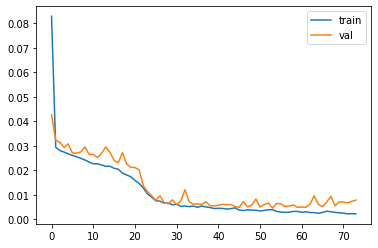

---Training time: 100.61146045 seconds ---


In [ ]:
# Train The Model
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=20,verbose=1, mode='auto') 
checkpoint = ModelCheckpoint('/content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Standalone/Check', monitor='val_loss', verbose=1, save_best_only=True, mode='min')  
callbacks_list = [earlystop, checkpoint]
start_time = time.time()
history = model.fit([X_train],[Y_train_SS,Y_train_V], epochs=100, batch_size=32,callbacks=callbacks_list,
                     validation_data=([X_val],[Y_val_SS,Y_val_V]), verbose=1)
end_time = time.time()
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()
print("---Training time: %0.8f seconds ---" % (end_time - start_time))

In [ ]:
# Model Performance: Training
y_predtrain = model.predict([X_train])
y_predtrain_SS = np.array(y_predtrain)[0,] 
y_predtrain_V =np.array(y_predtrain)[1,] 

train_r2_SS = r2_score(Y_train_SS, y_predtrain_SS) 
train_rmse_SS = np.sqrt(mean_squared_error(Y_train_SS, y_predtrain_SS)) 

train_r2_V = r2_score(Y_train_V,y_predtrain_V ) 
train_rmse_V = np.sqrt(mean_squared_error(Y_train_V, y_predtrain_V )) 

# Model Performance: Validation 
y_predval = model.predict([X_val])
y_predval_SS = np.array(y_predval)[0,] 
y_predval_V = np.array(y_predval)[1,] 

val_r2_SS = r2_score(Y_val_SS, y_predval_SS) 
val_rmse_SS = np.sqrt(mean_squared_error(Y_val_SS, y_predval_SS)) 

val_r2_V = r2_score(Y_val_V, y_predval_V) 
val_rmse_V = np.sqrt(mean_squared_error(Y_val_V, y_predval_V)) 

# Model Performance: Testing
y_predtest = model.predict([x_test])
y_predtest_SS =np.array(y_predtest)[0,] 
y_predtest_V = np.array(y_predtest)[1,] 

test_r2_SS = r2_score(y_test_SS,y_predtest_SS) 
test_rmse_SS = np.sqrt(mean_squared_error(y_test_SS, y_predtest_SS)) 

test_r2_V = r2_score(y_test_V,y_predtest_V) 
test_rmse_V = np.sqrt(mean_squared_error(y_test_V, y_predtest_V)) 

# Print R2 Results
print("R2 scores: Train (SS) - %0.5f, Train (V) - %0.5f" %(train_r2_SS , train_r2_V))
print("R2 scores: Validation (SS) - %0.5f, Validation (V) - %0.5f" %(val_r2_SS , val_r2_V))
print("R2 scores: Testing (SS) - %0.5f, Testing (V) - %0.5f" %(test_r2_SS , test_r2_V))

# Print RSME Results
print("RMSE scores: Train (SS) - %0.5f, Train (V) - %0.5f" %(train_rmse_SS , train_rmse_V))
print("RMSE scores: Validation (SS) - %0.5f, Validation (V) - %0.5f" %(val_rmse_SS , val_rmse_V))
print("RMSE scores: Testing (SS) - %0.5f, Testing (V) - %0.5f" %(test_rmse_SS , test_rmse_V))

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


R2 scores: Train (SS) - 0.96761, Train (V) - 0.96047
R2 scores: Validation (SS) - 0.84641, Validation (V) - 0.84897
R2 scores: Testing (SS) - -0.21964, Testing (V) - -7.24242
RMSE scores: Train (SS) - 0.03332, Train (V) - 0.01928
RMSE scores: Validation (SS) - 0.07918, Validation (V) - 0.03938
RMSE scores: Testing (SS) - 0.24185, Testing (V) - 0.33355


In [ ]:
# Inverse scaling: SS 
Y_train_SS = scaler_ss.inverse_transform(Y_train_SS)
Y_val_SS = scaler_ss.inverse_transform(Y_val_SS)
y_test_SS = scaler_ss.inverse_transform(y_test_SS)
y_predtrain_SS = scaler_ss.inverse_transform(y_predtrain_SS)
y_predval_SS = scaler_ss.inverse_transform(y_predval_SS)
y_predtest_SS = scaler_ss.inverse_transform(y_predtest_SS)

In [ ]:
# Inverse scaling: V
Y_train_V = scaler_v.inverse_transform(Y_train_V)
Y_val_V = scaler_v.inverse_transform(Y_val_V)
y_test_V = scaler_v.inverse_transform(y_test_V)
y_predtrain_V = scaler_v.inverse_transform(y_predtrain_V)
y_predval_V = scaler_v.inverse_transform(y_predval_V)
y_predtest_V = scaler_v.inverse_transform(y_predtest_V)

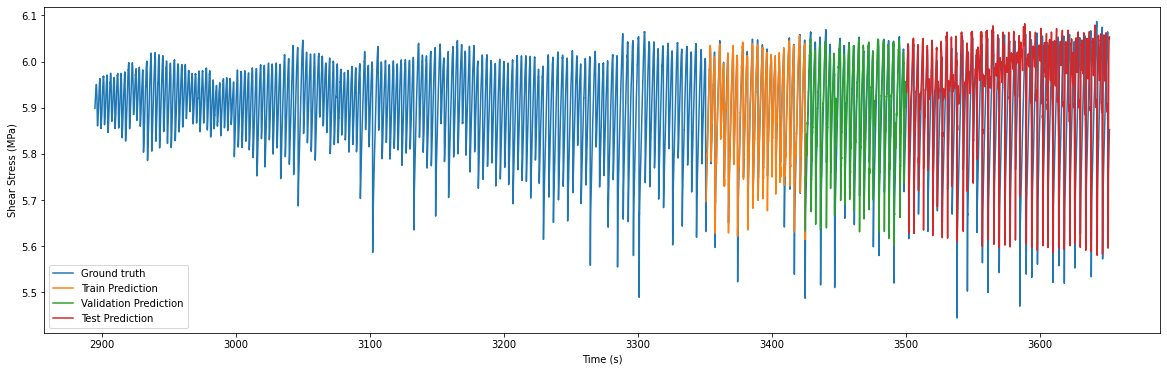

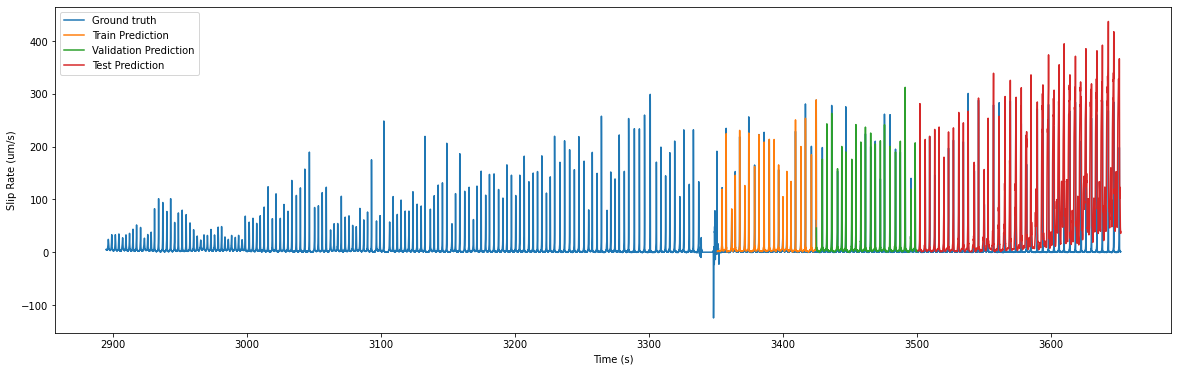

In [ ]:
# Overall plot: SS & V
ttime = df['Time'][n_steps:]
t1, testtime = train_test_split(ttime, test_size=0.2, shuffle=False)
traintime, valtime = train_test_split(t1, test_size=0.125, shuffle=False)

traintime = traintime[45599:53199] 

fig = plt.figure(1, figsize=(20,6))
plt.plot(ttime, ydf_SS)
plt.plot(traintime, y_predtrain_SS)
plt.plot(valtime, y_predval_SS)
plt.plot(testtime, y_predtest_SS)
plt.xlabel('Time (s)')
plt.ylabel('Shear Stress (MPa)')
plt.legend(['Ground truth', 'Train Prediction', 'Validation Prediction', 'Test Prediction'])

fig = plt.figure(2, figsize=(20,6))
plt.plot(ttime, ydf_V)
plt.plot(traintime, y_predtrain_V)
plt.plot(valtime,  y_predval_V)
plt.plot(testtime, y_predtest_V)
plt.xlabel('Time (s)')
plt.ylabel('Slip Rate (um/s)')
plt.legend(['Ground truth', 'Train Prediction', 'Validation Prediction', 'Test Prediction'])

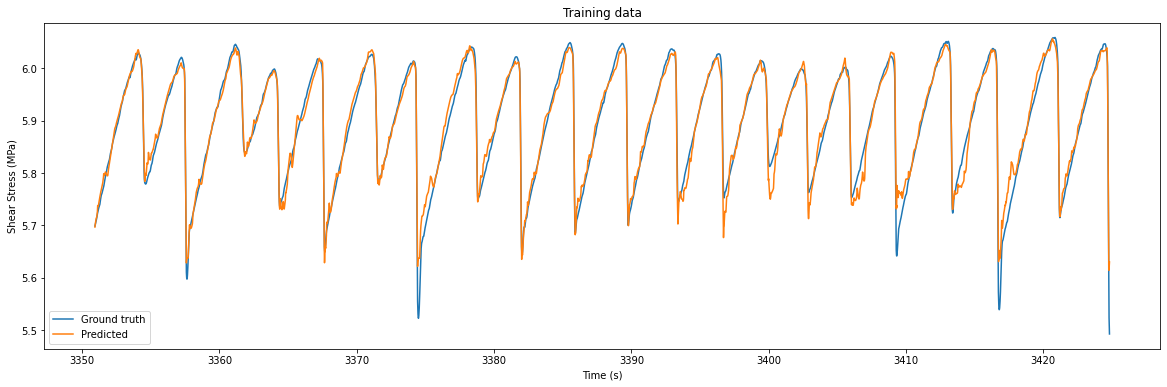

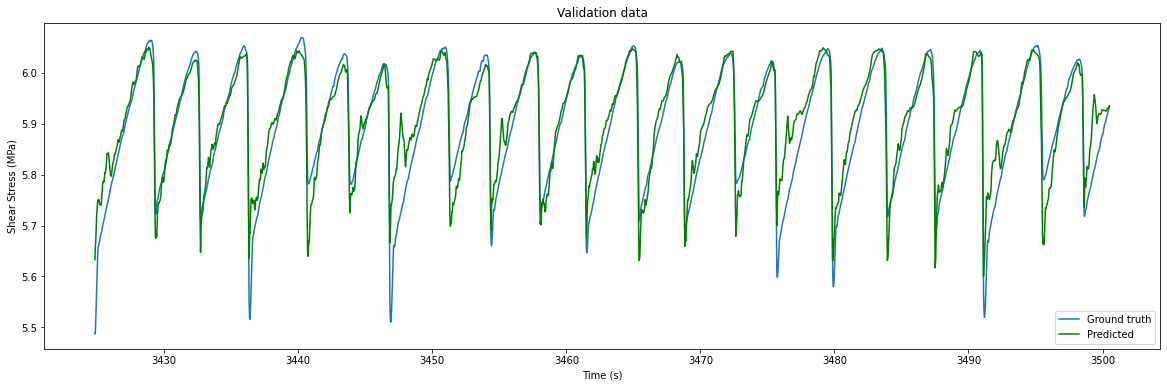

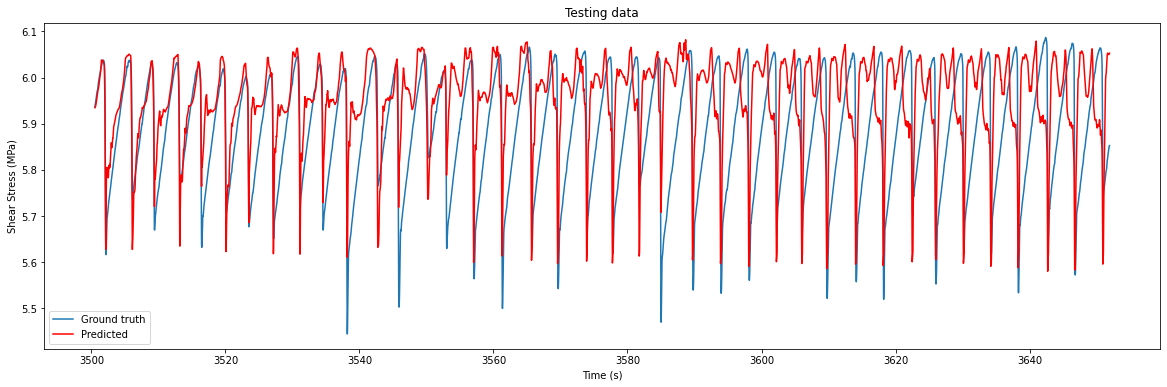

In [ ]:
# # Individual plot: SS

def results_plot(fig_no, t, gt, pred, title, col):
  fig = plt.figure(fig_no, figsize=(20,6))
  plt.plot(t, gt)
  plt.plot(t, pred, col)
  plt.xlabel('Time (s)')
  plt.ylabel('Shear Stress (MPa)')
  plt.legend(['Ground truth', 'Predicted'])
  plt.title(title)

results_plot(1, traintime, Y_train_SS, y_predtrain_SS, 'Training data', '')
results_plot(2, valtime, Y_val_SS, y_predval_SS, 'Validation data', 'g')
results_plot(3, testtime, y_test_SS, y_predtest_SS, 'Testing data', 'r')

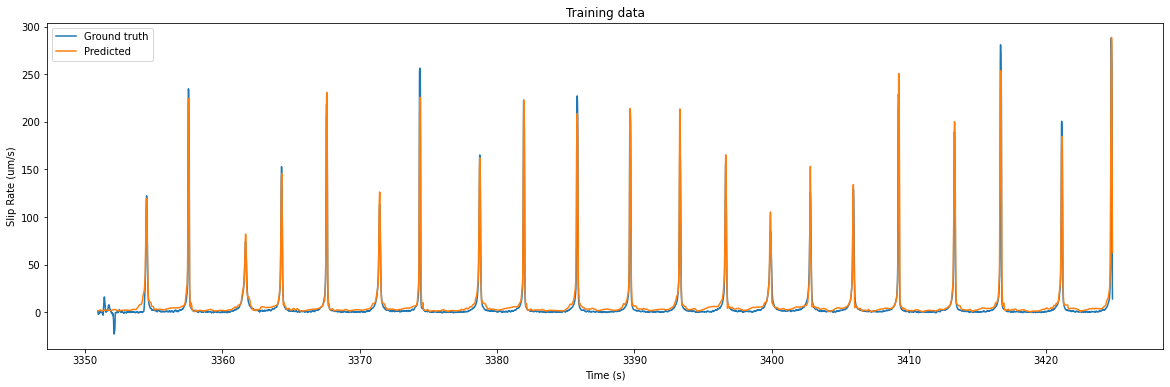

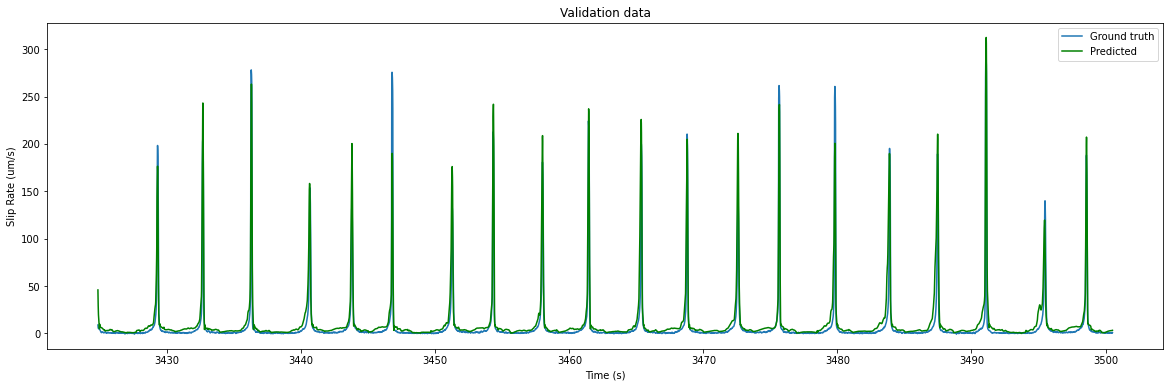

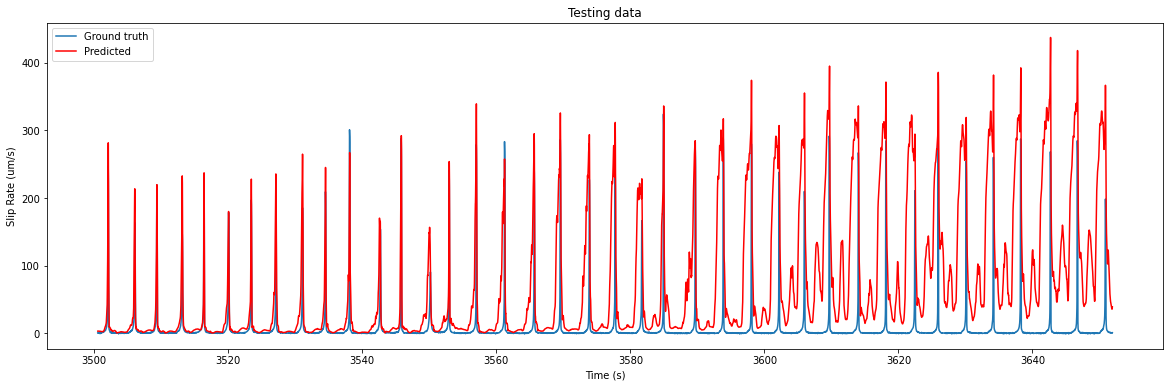

In [ ]:
# # Individual plot: V

def results_plot(fig_no, t, gt, pred, title, col):
  fig = plt.figure(fig_no, figsize=(20,6))
  plt.plot(t, gt)
  plt.plot(t, pred, col)
  plt.xlabel('Time (s)')
  plt.ylabel('Slip Rate (um/s)')
  plt.legend(['Ground truth', 'Predicted'])
  plt.title(title)

results_plot(1, traintime, Y_train_V, y_predtrain_V, 'Training data', '')
results_plot(2, valtime, Y_val_V, y_predval_V, 'Validation data', 'g')
results_plot(3, testtime, y_test_V, y_predtest_V, 'Testing data', 'r')